In [1]:
from helper import *
from tqdm import tqdm

In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_precision_recall_curve, recall_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA

In [7]:
answers = read_json('../data/kg/answers.json')
questions = list(answers.keys())
questions_train, questions_test = train_test_split(questions, random_state = 0, test_size = 0.5)
data = []
positives = 0
for q in tqdm(questions_train):
    q_len = len(find_keywords(q))
    for sentence in answers[q]:
        positives += sentence['isCorrect']
        row = [sentence['sent_stemmed_overlap'], sentence['sent_text'], sentence['sent_tokens'], sentence['nbr_text'], sentence['nbr_tokens'], sentence['topic1'], sentence['topic2'], sentence['answer_type']]
        row = list(map(lambda x: x/q_len, row))
        row.append(sentence['isCorrect'])
        data.append(row)
print(data[0])


100%|██████████| 43/43 [00:02<00:00, 15.38it/s]

[1.0, 0.08477825938134742, 0.4808983469629878, 0.08477825938134742, 0.4808983469629878, 0.0, 0.0, 0.0, True]


100%|██████████| 43/43 [00:03<00:00, 11.24it/s]


[21, 25, 25, 29, 31, 32, 32, 33, 34, 34, 34, 35, 36, 37, 38, 39, 39, 39, 41, 41] 43


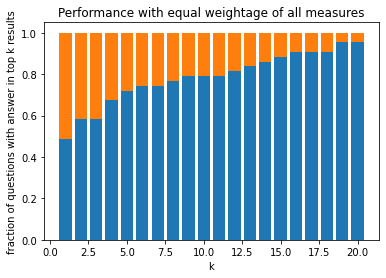

In [8]:
weights = [1] * 8
k = 20
top_k = [0 for i in range(k)]
for q in tqdm(questions_test):
    q_len = len(find_keywords(q))
    ranks = []
    for sentence in answers[q]:
        positives += sentence['isCorrect']
        row = [sentence['sent_stemmed_overlap'], sentence['sent_text'], sentence['sent_tokens'], sentence['nbr_text'], sentence['nbr_tokens'], sentence['topic1'], sentence['topic2'], sentence['answer_type']]
        row = list(map(lambda x: x/q_len, row))
        score = sum([row[i] * weights[i] for i in range(len(row))])
        ranks.append((score, sentence['isCorrect']))
    ranks.sort(reverse = True)
    ranks = ranks[:k]
    found = False
    for i in range(k):
        if i < len(ranks) and ranks[i][1]:
            found = True
        if found:
            top_k[i] += 1
print(top_k, len(questions_test))
top_k = list(map(lambda x: x/len(questions_test), top_k))
import matplotlib.pyplot as plt
plt.bar(range(1, k + 1),top_k)
plt.bar(range(1, k + 1), list(map(lambda x: 1 - x, top_k)), bottom = top_k)
plt.xlabel('k')
plt.ylabel('fraction of questions with answer in top k results')
plt.title('Performance with equal weightage of all measures')
plt.savefig('../data/kg/performance_without_reranking')
plt.show()

In [9]:
clf = LogisticRegression(class_weight = {0: positives, 1: len(data) - positives})
X = np.array([list(map(float, row[:-1])) for row in data])
y = np.array([int(row[-1]) for row in data])
print([i for i in y].count(1))

for train_index, test_index in KFold(n_splits = 5, shuffle = True, random_state = 0).split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    print('weights:', clf.coef_[0])
    print('accuracy:', clf.score(X_test, y_test), 'recall:', recall_score(y_test, clf.predict(X_test)))
    print()
clf.fit(X, y)
weights = clf.coef_[0]

61
weights: [1.43521499 8.11611115 1.17422677 0.63320961 1.17422677 1.41831544
 0.60945888 0.        ]
accuracy: 0.8948571428571429 recall: 0.5833333333333334

weights: [1.44536789 5.75186683 0.9485656  1.83149021 0.9485656  1.53953676
 0.93274203 0.        ]
accuracy: 0.8845714285714286 recall: 0.7

weights: [1.07771522 6.07319056 0.80014353 1.97900353 0.80014353 1.52287968
 0.96735058 0.        ]
accuracy: 0.9005714285714286 recall: 0.7142857142857143

weights: [2.14790227 6.75987016 0.67565559 1.48550616 0.67565559 1.53185039
 0.88588926 0.        ]
accuracy: 0.8981693363844394 recall: 0.4444444444444444

weights: [1.59285005 5.58158161 0.88877755 1.67048323 0.88877755 1.41899997
 0.98033186 0.        ]
accuracy: 0.9084668192219679 recall: 0.4375



  5%|▍         | 2/43 [00:00<00:03, 11.45it/s]

weights: [1.51643347 6.35836891 0.89685278 1.60378636 0.89685278 1.47544813
 0.88040862 0.        ]


100%|██████████| 43/43 [00:01<00:00, 22.42it/s]


[18, 22, 26, 31, 34, 36, 38, 38, 38, 38, 38, 39, 39, 39, 40, 41, 41, 41, 41, 41] 43


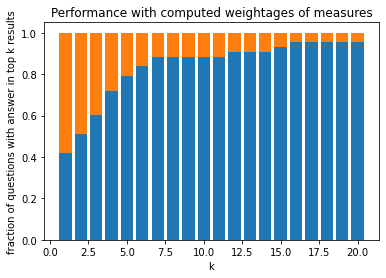

In [22]:
print('weights:', weights)
k = 20
top_k = [0 for i in range(k)]
for q in tqdm(questions_test):
    q_len = len(find_keywords(q))
    ranks = []
    for sentence in answers[q]:
        positives += sentence['isCorrect']
        row = [sentence['sent_stemmed_overlap'], sentence['sent_text'], sentence['sent_tokens'], sentence['nbr_text'], sentence['nbr_tokens'], sentence['topic1'], sentence['topic2'], sentence['answer_type']]
        row = list(map(lambda x: x/q_len, row))
        score = sum([row[i] * weights[i] for i in range(len(row))])
        ranks.append((score, sentence['isCorrect']))
    ranks.sort(reverse = True)
    ranks = ranks[:k]
    found = False
    for i in range(k):
        if i < len(ranks) and ranks[i][1]:
            found = True
        if found:
            top_k[i] += 1
print(top_k, len(questions_test))
top_k = list(map(lambda x: x/len(questions_test), top_k))
import matplotlib.pyplot as plt
plt.bar(range(1, k + 1),top_k)
plt.bar(range(1, k + 1), list(map(lambda x: 1 - x, top_k)), bottom = top_k)
plt.xlabel('k')
plt.ylabel('fraction of questions with answer in top k results')
plt.title('Performance with computed weightages of measures')
plt.savefig('../data/kg/performance_with_reranking')
plt.show()

In [32]:
top_k = [18, 22, 26, 31, 34, 36, 38, 38, 38, 38, 38, 39, 39, 39, 40, 41, 41, 41, 41, 41]
a = 0
for i in range(len(top_k)):
    top_k[i] -= a
    a += top_k[i]
    top_k[i] /= (i + 1)
print(sum(top_k)/43)

top_k = [21, 25, 25, 29, 31, 32, 32, 33, 34, 34, 34, 35, 36, 37, 38, 39, 39, 39, 41, 41]
a = 0
for i in range(len(top_k)):
    top_k[i] -= a
    a += top_k[i]
    top_k[i] /= (i + 1)
print(sum(top_k)/43)


0.558485603543743
0.587648664744748


In [24]:
print(sum(top_k)/20)

0.16511627906976747
